<a href="https://colab.research.google.com/github/MichalStrus/Ultrasound-image-of-breast-classification/blob/main/CNN_Classification_for_Ultrasound_breast_photos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [2]:
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
import seaborn as sns

# Data loading and first view of the dataset

In [3]:
data = tf.keras.utils.image_dataset_from_directory("/content/drive/MyDrive/data-science-bootcamp/dataset_breast_ultrasound", labels = 'inferred', label_mode = 'int', class_names = ['normal', 'malignant', 'benign'], batch_size =  25)

Found 780 files belonging to 3 classes.


In [4]:
data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

Now let's split our data to train, validation and test sets

In [5]:
len(data)

32

In [6]:
data_iterator = data.as_numpy_iterator()

In [7]:
data_iterator

In [8]:
batch = data_iterator.next()

In [9]:
batch[1]

array([0, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 0, 2, 0, 2, 0, 2, 2, 0, 2, 0,
       2, 2, 2], dtype=int32)

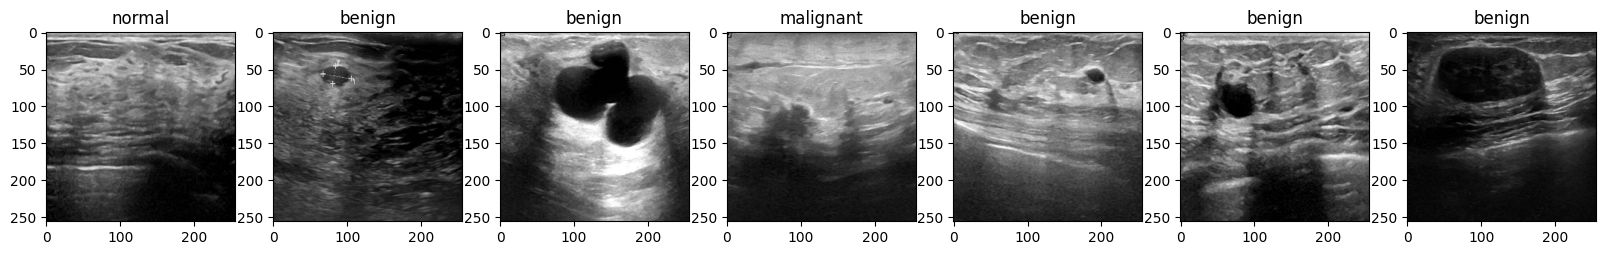

In [10]:
fig,ax = plt.subplots(ncols = 7, figsize = (20,20))
for idx, img in enumerate(batch[0][:7]):
  ax[idx].imshow(img.astype(int))
  if (batch[1][idx] == 0):
    ax[idx].title.set_text("normal")
  elif (batch[1][idx] == 1):
    ax[idx].title.set_text("malignant")
  else:
    ax[idx].title.set_text("benign")

# Data preprocessing

Mapping the data to interval [0,1]

In [11]:
data = data.map(lambda x, y: (x/255, y))

## Data split into train, validation and test set

In [12]:
num_train_samples = int(0.8 * len(data))
train_data = data.take(num_train_samples)
val_data = data.skip(num_train_samples)

In [13]:
len(train_data)

25

In [14]:
num_val_samples = len(val_data) // 2
test_data = val_data.skip(num_val_samples)
val_data = val_data.take(num_val_samples)

In [15]:
len(val_data)

3

In [16]:
len(test_data)

4

Quick view of the data combined in the train_data

In [ ]:
for idx,i in enumerate(train_data):
  if (idx <=100):
    print(i)
  else:
    break

# Model

## Convolutional Neural Network

In [18]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras import callbacks

I used 128 and 64 convolution filters in convolution layers and strides means that filters are moving by 1 pixel, I also used BatchNormalization after each sequence of convolution, MaxPooling2D takes only influential features and reduce the dimension of the data. At the end flattened the data and used 2 layers of neurons (128 in first and 3 in last, because there were 3 classes)

In [19]:
model = Sequential()
model.add(Conv2D(filters = 128, kernel_size = (3,3), strides = 1, activation = 'sigmoid', padding = 'same', input_shape = (256,256,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(Conv2D(filters = 64, kernel_size = (3,3), strides = 1, activation = 'sigmoid', padding = 'same'))
model.add(BatchNormalization())

model.add(Conv2D(filters = 128, kernel_size = (3,3), strides = 1, activation = 'sigmoid', padding = 'same'))
model.add(BatchNormalization())

model.add(Conv2D(filters = 64, kernel_size = (3,3), strides = 1, activation = 'sigmoid', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(Flatten())


I used softmax function, because it is multi-class classification problem

In [20]:
x = model.output
x = Dense(128, activation = 'sigmoid')(x)
prediction_layer = Dense(3, activation = 'softmax')(x)

I use sparse_categorical_crossentropy because the labels are not one-hot encoded which is the case of using categorical_crossentropy. Rmsprop is used here, because it's great optimizer for image classification. The model is optimized for accuracy.

In [21]:
cnn_model = Model(inputs= model.input, outputs = prediction_layer)
cnn_model.compile(optimizer = 'rmsprop', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
cnn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 128)     3584      
                                                                 
 batch_normalization (Batch  (None, 256, 256, 128)     512       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 128)     0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      73792     
                                                                 
 batch_normalization_1 (Bat  (None, 128, 128, 64)      256   

In [22]:
history = cnn_model.fit(train_data, epochs = 20, validation_data = val_data)

Epoch 1/20
25/25 [==============================] - 28s 574ms/step - loss: 1.5619 - accuracy: 0.5376 - val_loss: 2.0234 - val_accuracy: 0.6267
Epoch 2/20
25/25 [==============================] - 16s 568ms/step - loss: 0.9832 - accuracy: 0.5760 - val_loss: 2.2032 - val_accuracy: 0.5600
Epoch 3/20
25/25 [==============================] - 15s 559ms/step - loss: 0.9619 - accuracy: 0.5664 - val_loss: 1.8129 - val_accuracy: 0.5600
Epoch 4/20
25/25 [==============================] - 16s 575ms/step - loss: 0.9520 - accuracy: 0.5456 - val_loss: 1.8341 - val_accuracy: 0.5867
Epoch 5/20
25/25 [==============================] - 15s 566ms/step - loss: 0.9472 - accuracy: 0.5600 - val_loss: 1.3166 - val_accuracy: 0.5733
Epoch 6/20
25/25 [==============================] - 17s 625ms/step - loss: 0.9234 - accuracy: 0.5888 - val_loss: 1.4983 - val_accuracy: 0.5067
Epoch 7/20
25/25 [==============================] - 15s 568ms/step - loss: 0.9283 - accuracy: 0.5792 - val_loss: 1.5209 - val_accuracy: 0.6133

# Data visualization

## Traing and validation loss of CNN

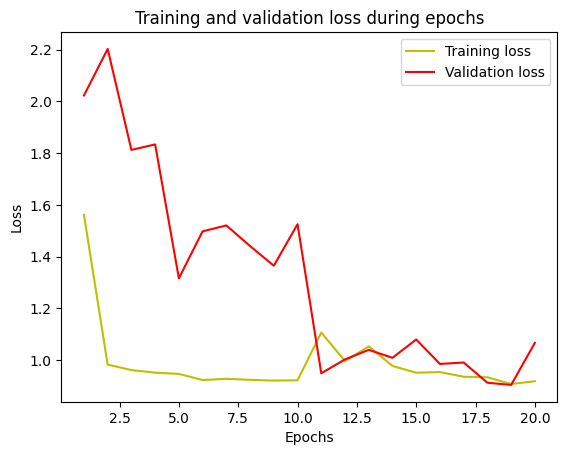

In [23]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(loss)+1)
plt.plot(epochs, loss, 'y', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss during epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

As we can see the data CNN is not well fitted with the training data and the loss is only decreasing for validation data, but not clearly. It might be the reason of tough decision problem and the distribution of classes

## Training and validation accuracy of CNN

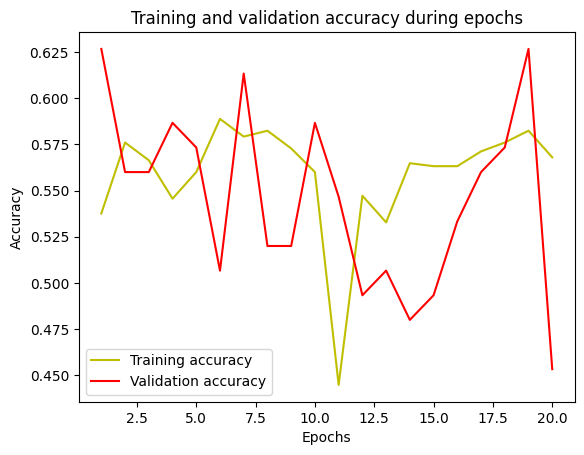

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1,len(acc)+1)
plt.plot(epochs, acc, 'y', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation accuracy')
plt.title('Training and validation accuracy during epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The training and validation accuracy seems to be random and it is not increasing at all

# Model test

In [25]:
pred_NN = cnn_model.predict(test_data)
#pred_NN = np.argmax(pred_NN, axis =-1)

4/4 [==============================] - 9s 388ms/step


In [26]:
y_test = np.empty((80,1))
idx=0
for batch in test_data.as_numpy_iterator():
  X,y =batch
  for i in y:
    y_test[idx] = i
    idx+=1

In [27]:
y_test

array([[0.],
       [1.],
       [1.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [1.],
       [2.],
       [1.],
       [2.],
       [2.],
       [2.],
       [1.],
       [2.],
       [2.],
       [2.],
       [1.],
       [1.],
       [1.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [1.],
       [2.],
       [0.],
       [2.],
       [2.],
       [1.],
       [1.],
       [2.],
       [2.],
       [2.],
       [2.],
       [1.],
       [2.],
       [2.],
       [2.],
       [1.],
       [0.],
       [2.],
       [2.],
       [2.],
       [1.],
       [2.],
       [0.],
       [2.],
       [2.],
       [1.],
       [2.],
       [0.],
       [1.],
       [1.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [1.],
       [1.],
       [0.],
       [1.],
       [2.],
       [1.],
       [0.],
       [2.],

In [28]:
pred_NN

array([[0.14188588, 0.3458775 , 0.5122366 ],
       [0.14188597, 0.34587747, 0.51223654],
       [0.14185423, 0.3458349 , 0.51231086],
       [0.13955672, 0.3428404 , 0.51760286],
       [0.1418858 , 0.34587756, 0.51223665],
       [0.14188626, 0.34587735, 0.5122364 ],
       [0.13195656, 0.33263028, 0.53541315],
       [0.14730316, 0.34455228, 0.50814456],
       [0.13505954, 0.33680296, 0.52813745],
       [0.1418858 , 0.34587753, 0.51223665],
       [0.13731292, 0.32473782, 0.53794926],
       [0.12674476, 0.3164208 , 0.55683446],
       [0.14980163, 0.4673184 , 0.38288003],
       [0.14945015, 0.46739227, 0.38315752],
       [0.1418846 , 0.3458731 , 0.5122423 ],
       [0.12446404, 0.29694563, 0.57859033],
       [0.12464366, 0.2929958 , 0.58236057],
       [0.14188582, 0.34587753, 0.5122366 ],
       [0.14102983, 0.41289702, 0.44607309],
       [0.12463075, 0.29170927, 0.58365995],
       [0.14021838, 0.35283732, 0.5069443 ],
       [0.12496109, 0.3228238 , 0.5522151 ],
       [0.

In [29]:
y_test = y_test.reshape(-1)

## Confusion Matrix of CNN

[[ 0  0  0]
 [ 0  0  4]
 [11 23 42]]


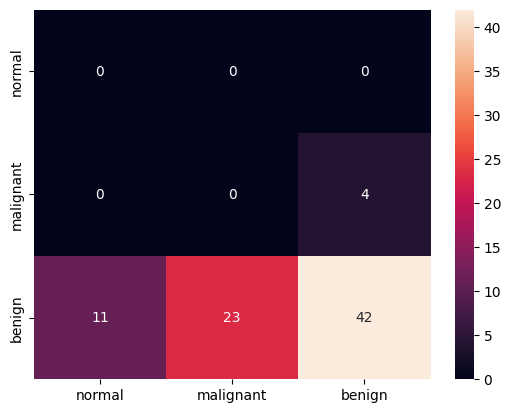

In [30]:
cm = confusion_matrix(np.argmax(pred_NN, axis=1), y_test)
print(cm)
labels = ['normal', 'malignant', 'benign']
sns.heatmap(cm, annot=True, xticklabels=labels, yticklabels=labels)
plt.show()

As we can see, there is a class disbalance and the most frequent class is being predicted quite often, so let's see how the Random Forest is gonna work with the features extracted with convolutional filters!

## Random Forest

In [31]:
data_RF_train = []
y_train = []

# Pobranie cech wyjściowych z modelu dla danych treningowych
for x_batch, y_batch in train_data:
    data_RF_train.append(model.predict(x_batch))  # Pobranie cech wyjściowych
    y_train.append(y_batch)  # Pobranie etykiet

# Konwersja list na tablice numpy
data_RF_train = np.concatenate(data_RF_train)
y_train = np.concatenate(y_train)

1/1 [==============================] - 0s 30ms/step


In [32]:
RF = RandomForestClassifier(n_estimators=100,random_state = 1)
RF.fit(data_RF_train, y_train)

RandomForestClassifier(random_state=1)

In [33]:
data_RF_test = []
y_test = []

# Pobranie cech wyjściowych z modelu dla danych treningowych
for x_batch, y_batch in test_data:
    data_RF_test.append(model.predict(x_batch))  # Pobranie cech wyjściowych
    y_test.append(y_batch)  # Pobranie etykiet

# Konwersja list na tablice numpy
data_RF_test = np.concatenate(data_RF_test)
y_test = np.concatenate(y_test)

1/1 [==============================] - 0s 19ms/step


In [34]:
prediction_RF = RF.predict(data_RF_test)

In [35]:
prediction_RF

array([2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 0, 2, 1,
       2, 0, 2, 2, 0, 0, 2, 2, 2, 2, 0, 2, 2, 1, 2, 2, 2, 2, 2, 0, 2, 0,
       2, 0, 2, 2, 2, 2, 2, 2, 1, 0, 0, 2, 1, 0, 2, 2, 2, 2, 2, 2, 1, 1,
       1, 2, 1, 0, 2, 2, 2, 2, 1, 2, 2, 0, 0, 2], dtype=int32)

In [47]:
data_RF_val = []
y_val = []

# Pobranie cech wyjściowych z modelu dla danych treningowych
for x_batch, y_batch in val_data:
    data_RF_val.append(model.predict(x_batch))  # Pobranie cech wyjściowych
    y_val.append(y_batch)  # Pobranie etykiet

# Konwersja list na tablice numpy
data_RF_val = np.concatenate(data_RF_val)
y_val = np.concatenate(y_val)

1/1 [==============================] - 0s 27ms/step


In [48]:
pred_RF_val = RF.predict(data_RF_val)

## Confusion Matrix of Random Forest

## CM for validation data

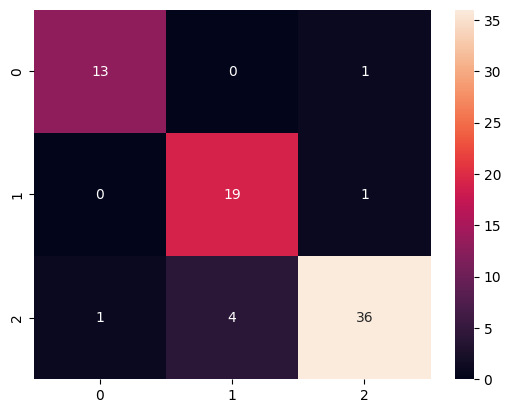

In [49]:
cm = confusion_matrix(pred_RF_val, y_val)
sns.heatmap(cm, annot = True)
plt.show()

In [59]:
acc_val = accuracy_score(pred_RF_val, y_val)

In [60]:
acc_val

0.9066666666666666

## CM for test data

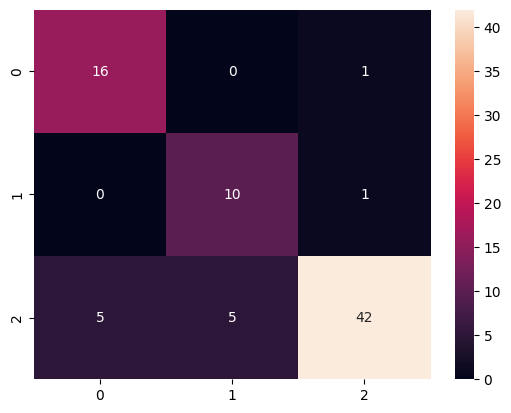

In [50]:
cm = confusion_matrix(prediction_RF, y_test)
sns.heatmap(cm, annot = True)
plt.show()

As we can see the model is great it has accuracy on 0.92 level. I think this result could be even higher if the classes were more balanced, but model is good even for less frequent classes(normal and malignant)

In [57]:
acc_test = accuracy_score(prediction_RF, y_test)

In [58]:
acc_test

0.85

In [54]:
from sklearn.metrics import classification_report
print(classification_report(y_test,prediction_RF))

              precision    recall  f1-score   support

           0       0.94      0.76      0.84        21
           1       0.91      0.67      0.77        15
           2       0.81      0.95      0.88        44

    accuracy                           0.85        80
   macro avg       0.89      0.79      0.83        80
weighted avg       0.86      0.85      0.85        80



As we can see almost every metric(precision,recall,f1) is good or great for my model based on both validation and test data

In [55]:
from sklearn.metrics import classification_report
print(classification_report(y_val,pred_RF_val))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93        14
           1       0.95      0.83      0.88        23
           2       0.88      0.95      0.91        38

    accuracy                           0.91        75
   macro avg       0.92      0.90      0.91        75
weighted avg       0.91      0.91      0.91        75



Total accuracy for combined test and validation data (155 observations)

In [61]:
(acc_test*len(y_test)+acc_val*len(y_val))/(len(y_test)+len(y_val))

0.8774193548387097

# Prediction on single photos

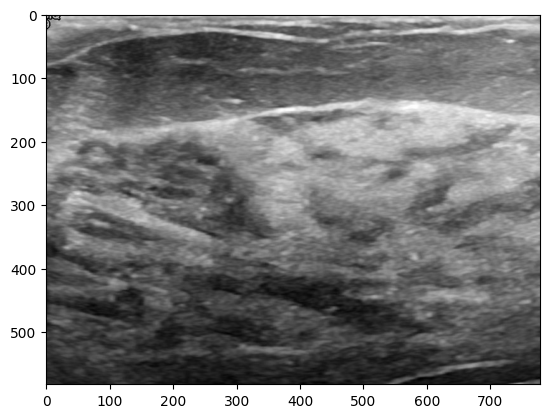

In [62]:
img = cv2.imread("/content/drive/MyDrive/data-science-bootcamp/normal (12).png")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

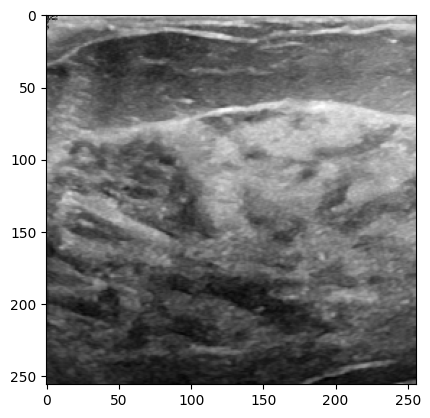

In [63]:
resize=tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [64]:
resize = resize / 255.0

In [65]:
resize

<tf.Tensor: shape=(256, 256, 3), dtype=float32, numpy=
array([[[0.51472104, 0.51472104, 0.51472104],
        [0.01622002, 0.01622002, 0.01622002],
        [0.7272959 , 0.7272959 , 0.7272959 ],
        ...,
        [0.8117963 , 0.8117963 , 0.8117963 ],
        [0.79356736, 0.79356736, 0.79356736],
        [0.79097795, 0.79097795, 0.79097795]],

       [[0.45712796, 0.45712796, 0.45712796],
        [0.01364824, 0.01364824, 0.01364824],
        [0.711583  , 0.711583  , 0.711583  ],
        ...,
        [0.83006644, 0.83006644, 0.83006644],
        [0.83178025, 0.83178025, 0.83178025],
        [0.77042913, 0.77042913, 0.77042913]],

       [[0.7034118 , 0.7034118 , 0.7034118 ],
        [0.01163523, 0.01163523, 0.01163523],
        [0.73685306, 0.73685306, 0.73685306],
        ...,
        [0.7882346 , 0.7882346 , 0.7882346 ],
        [0.7732661 , 0.7732661 , 0.7732661 ],
        [0.6590677 , 0.6590677 , 0.6590677 ]],

       ...,

       [[0.17103247, 0.17103247, 0.17103247],
        [0.16

In [66]:
yhat = model.predict(np.expand_dims(resize, 0))

1/1 [==============================] - 1s 602ms/step


In [67]:
yhat

array([[ 0.9862383 ,  0.97483325,  1.0259582 , ..., -0.8270232 ,
        -0.7566319 ,  0.94068676]], dtype=float32)

In [68]:
yhat = RF.predict(yhat)

In [69]:
if (yhat[0] == 0):
  print("normal")
elif (yhat[0] == 1):
  print("malignant")
else:
  print("benign")

normal


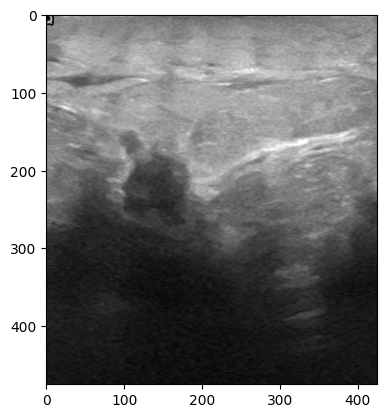

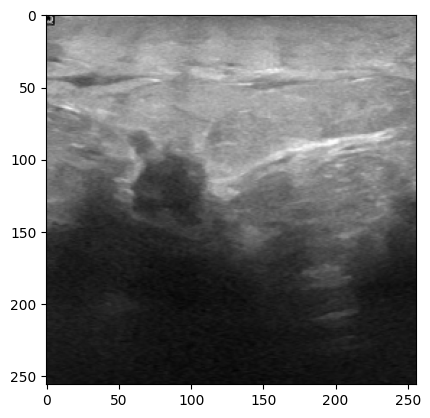

1/1 [==============================] - 0s 19ms/step
malignant


In [70]:
img = cv2.imread("/content/drive/MyDrive/data-science-bootcamp/malignant (3).png")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()
resize=tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()
resize = resize / 255.0
yhat = model.predict(np.expand_dims(resize, 0))
yhat = RF.predict(yhat)
if (yhat[0] == 0):
  print("normal")
elif (yhat[0] == 1):
  print("malignant")
else:
  print("benign")

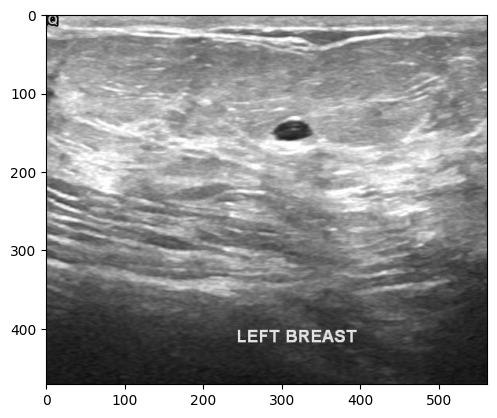

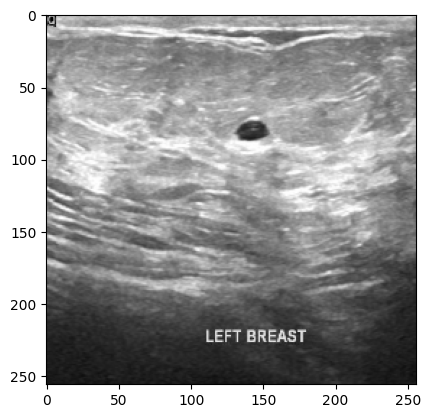

1/1 [==============================] - 0s 18ms/step
benign


In [71]:
img = cv2.imread("/content/drive/MyDrive/data-science-bootcamp/benign (1).png")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()
resize=tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()
resize = resize / 255.0
yhat = model.predict(np.expand_dims(resize, 0))
yhat = RF.predict(yhat)
if (yhat[0] == 0):
  print("normal")
elif (yhat[0] == 1):
  print("malignant")
else:
  print("benign")